# Regression in Python

***
This is a very quick run-through of some basic statistical concepts, adapted from [Lab 4 in Harvard's CS109](https://github.com/cs109/2015lab4) course. Please feel free to try the original lab if you're feeling ambitious :-) The CS109 git repository also has the solutions if you're stuck.

* Linear Regression Models
* Prediction using linear regression

Linear regression is used to model and predict continuous outcomes with normal random errors. There are nearly an infinite number of different types of regression models and each regression model is typically defined by the distribution of the prediction errors (called "residuals") of the type of data. **Logistic regression is used to model binary outcomes whereas Poisson regression is used to predict counts.** In this exercise, we'll see some examples of linear regression as well as Train-test splits.

The packages we'll cover are: `statsmodels`, `seaborn`, and `scikit-learn`. While we don't explicitly teach `statsmodels` and `seaborn` in the Springboard workshop, those are great libraries to know.
***

<img width=600 height=300 src="https://imgs.xkcd.com/comics/sustainable.png"/>


In [1]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import os 
import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
#sns.set_style("whitegrid")
sns.set_style("ticks", rc={"xtick.direction":"in", "ytick.direction":"in"})
#sns.set_context("poster")
sns.set_context("notebook", font_scale=1.5)

%matplotlib inline

***
# Part 1: Introduction to Linear Regression
### Purpose of linear regression
***
<div class="span5 alert alert-info">

<p> Given a dataset containing predictor variables $X$ and outcome/response variable $Y$, linear regression can be used to: </p>
<ul>
  <li> Build a <b>predictive model</b> to predict future values of $\hat{Y}$, using new data $X^*$ where $Y$ is unknown.</li>
  <li> Model the <b>strength of the relationship</b> between each independent variable $X_i$ and $Y$</li>
    <ul>
      <li> Many times, only a subset of independent variables $X_i$ will have a linear relationship with $Y$</li>
      <li> Need to figure out which $X_i$ contributes most information to predict $Y$ </li>
    </ul>
   <li>It is in many cases, the first pass prediction algorithm for continuous outcomes. </li>
</ul>
</div>

### A Brief Mathematical Recap
***

[Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as ***explanatory variables***, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is **linearly** related to the dependent variable $Y$. The most basic linear regression model contains one independent variable $X$, we'll call this the simple model. 

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where **$\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship.** In linear regression, $\epsilon$ is assumed to be normally distributed with a mean of 0. In other words, what this means is that on average, if we know $Y$, a roughly equal number of predictions $\hat{Y}$ will be above $Y$ and others will be below $Y$. That is, on average, the error is zero. The residuals, $\epsilon$ are also assumed to be "i.i.d.": independently and identically distributed. Independence means that the residuals are not correlated -- the residual from one prediction has no effect on the residual from another prediction. Correlated errors are common in time series analysis and spatial analyses.

* $\beta_0$ is the intercept of the linear model and represents the average of $Y$ when all independent variables $X$ are set to 0.

* $\beta_1$ is the slope of the line associated with the regression model and represents the average effect of a one-unit increase in $X$ on $Y$.

* Back to the simple model. The model in linear regression is the *conditional mean* of $Y$ given the values in $X$ is expressed a linear function.  

$$ y = f(x) = E(Y | X = x)$$ 

![conditional mean](images/conditionalmean.png)
*Image from http://www.learner.org/courses/againstallodds/about/glossary.html. Note this image uses $\alpha$ and $\beta$ instead of $\beta_0$ and $\beta_1$.*

* The goal is to estimate the coefficients (e.g. $\beta_0$ and $\beta_1$). We represent the estimates of the coefficients with a "hat" on top of the letter.  

$$ \hat{\beta}_0, \hat{\beta}_1 $$

* Once we estimate the coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$, we can use these to predict new values of $Y$ given new data $X$.

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1$$

* Multiple linear regression is when you have more than one independent variable and the estimation involves matrices
    * $X_1$, $X_2$, $X_3$, $\ldots$


* How do you estimate the coefficients? 
    * There are many ways to fit a linear regression model
    * The method called **least squares** is the most common methods
    * We will discuss least squares

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 
    
### Estimating $\hat\beta$: Least squares
***
[Least squares](http://en.wikipedia.org/wiki/Least_squares) is a method that can estimate the coefficients of a linear model by minimizing the squared residuals: 

$$ \mathscr{L} = \sum_{i=1}^N \epsilon_i^2 = \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2  = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

where $N$ is the number of observations and $\epsilon$ represents a residual or error, ACTUAL - PREDICTED.  

#### Estimating the intercept $\hat{\beta_0}$ for the simple linear model

We want to minimize the squared residuals and solve for $\hat{\beta_0}$ so we take the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta_0}$ 

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_0}} &= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= -2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \hspace{25mm} \mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N (y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i) \\
&= -2 \left[ \left( \sum_{i=1}^N y_i \right) - N \hat{\beta_0} - \hat{\beta}_1 \left( \sum_{i=1}^N x_i
\right) \right] \\
& 2 \left[ N \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i \right] = 0 \hspace{20mm} \mbox{(Set equal to 0 and solve for $\hat{\beta}_0$)} \\
& N \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i = 0 \\
& N \hat{\beta}_0 = \sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i}{N} \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i}{N} - \hat{\beta}_1 \frac{\sum_{i=1}^N x_i}{N} \\
& \boxed{\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}}
\end{align}
$

Using this new information, we can compute the estimate for $\hat{\beta}_1$ by taking the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta}_1$.

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_1}} &= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= 2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \left( -x_i \right) \hspace{25mm}\mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N x_i \left( y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i \right) \\
&= -2 \sum_{i=1}^N x_i (y_i - \hat{\beta}_0 x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \sum_{i=1}^N x_i (y_i - \left( \bar{y} - \hat{\beta}_1 \bar{x} \right) x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \sum_{i=1}^N (x_i y_i - \bar{y}x_i + \hat{\beta}_1\bar{x}x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \left[ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i + \hat{\beta}_1\bar{x}\sum_{i=1}^N x_i - \hat{\beta}_1 \sum_{i=1}^N x_i^2 \right] \\
&= -2 \left[ \hat{\beta}_1 \left\{ \bar{x} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i^2 \right\} + \left\{ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i \right\}\right] \\
& 2 \left[ \hat{\beta}_1 \left\{ \sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i \right\} + \left\{ \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right\} \right] = 0 \\
& \hat{\beta}_1 = \frac{-\left( \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right)}{\sum_{i=1}^N x_i^2 - \bar{x}\sum_{i=1}^N x_i} \\
&= \frac{\sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i}{\sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i} \\
& \boxed{\hat{\beta}_1 = \frac{\sum_{i=1}^N x_i y_i - \bar{x}\bar{y}n}{\sum_{i=1}^N x_i^2 - n \bar{x}^2}}
\end{align}
$

The solution can be written in compact matrix notation as

$$\hat\beta =  (X^T X)^{-1}X^T Y$$ 

We wanted to show you this in case you remember linear algebra, in order for this solution to exist we need $X^T X$ to be invertible. Of course this requires a few extra assumptions, $X$ must be full rank so that $X^T X$ is invertible, etc. Basically, $X^T X$ is full rank if all rows and columns are linearly independent. This has a loose relationship to variables and observations being independent respective. **This is important for us because this means that having redundant features in our regression models will lead to poorly fitting (and unstable) models.** We'll see an implementation of this in the extra linear regression example.

***
# Part 2: Exploratory Data Analysis for Linear Relationships

The [Boston Housing data set](https://archive.ics.uci.edu/ml/datasets/Housing) contains information about the housing values in suburbs of Boston.  This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University and is now available on the UCI Machine Learning Repository. 


## Load the Boston Housing data set from `sklearn`
***

This data set is available in the [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston) python module which is how we will access it today.  

In [2]:
from sklearn.datasets import load_boston
import pandas as pd

#boston = load_boston()    # load_boston is deprecated as of sklearn version 1.2. 

bos = pd.read_csv('boston.csv', index_col=0)
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


<div class="alert alert-danger">
Since load_boston() function is deprecated and removed from sklearn (as of the version 1.2) due to ethical reason, alternatevely the dataset was stored to 'boston.csv' and re-arranged. If the dataset was read from the csv file directly, skip to <a href="#eda">EDA & Summary Statistics<\a>
<\div>

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of black people by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/


This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.

Now let's explore the data set itself. 

There are no column names in the DataFrame. Let's add those. 

Now we have a pandas DataFrame called `bos` containing all the data we want to use to predict Boston Housing prices.  Let's create a variable called `PRICE` which will contain the prices. This information is contained in the `target` data. 

<a id='eda'></a>
## EDA and Summary Statistics
***

Let's explore this data set.  First we use `describe()` to get basic summary statistics for each of the columns. 

In [3]:
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Scatterplots
***

Let's look at some scatter plots for three variables: 'CRIM' (per capita crime rate), 'RM' (number of rooms) and 'PTRATIO' (pupil-to-teacher ratio in schools).  

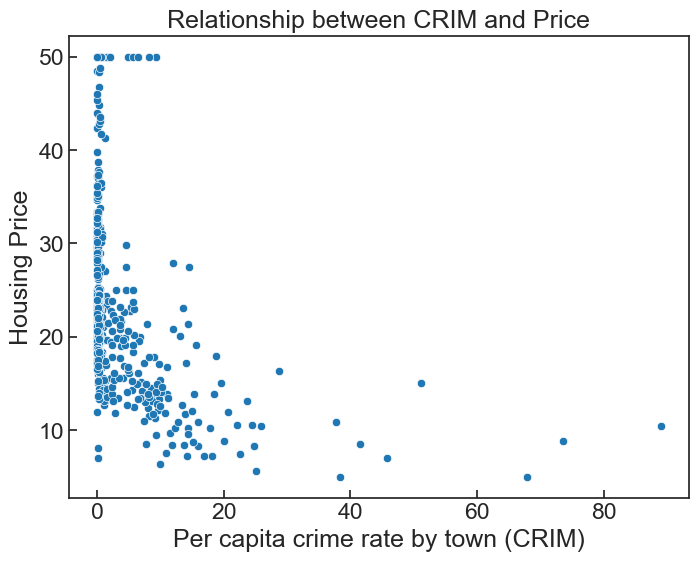

In [4]:
ax = sns.scatterplot(x=bos.CRIM, y=bos.PRICE)

ax.set_xlabel("Per capita crime rate by town (CRIM)")
ax.set_ylabel("Housing Price")
ax.set_title("Relationship between CRIM and Price");

<div class="span5 alert alert-info">
<h3>Part 2 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?</p>


<p><b>Exercise:</b> Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. Label your axes appropriately using human readable labels. Tell a story about what you see.</p>

<p><b>Exercise:</b> What are some other numeric variables of interest? Why do you think they are interesting? Plot scatterplots with these variables and *PRICE* (house price) and tell a story about what you see.</p>

</div>

**Exercise**: What kind of relationship do you see? e.g. positive, negative? linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?

> A) It appears that there may have a negative relationship between the housing price and the per capita crime rate. It is obvious that the housing price is very row when the crime rate is very high, but the price has an wide range when the crime rate is low. 

**Exercise:** Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. Label your axes appropriately using human readable labels. Tell a story about what you see.

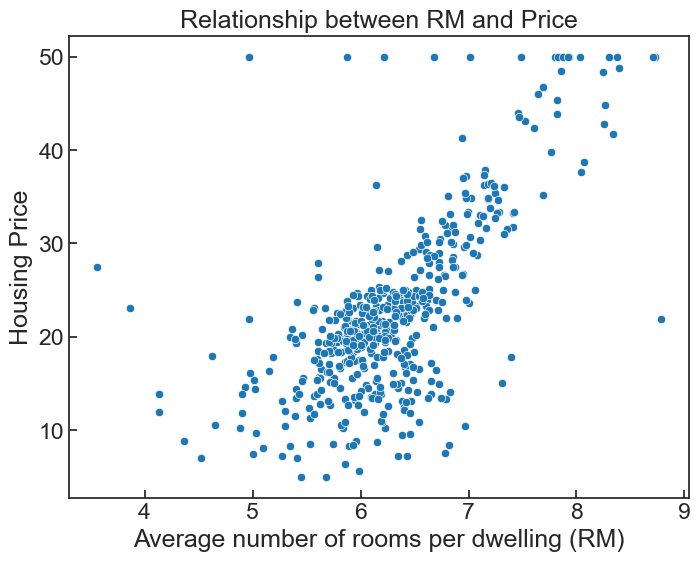

In [5]:
# your turn: scatter plot between *RM* and *PRICE*
ax = sns.scatterplot(x=bos.RM, y=bos.PRICE)

ax.set_xlabel("Average number of rooms per dwelling (RM)")
ax.set_ylabel("Housing Price")
ax.set_title("Relationship between RM and Price");

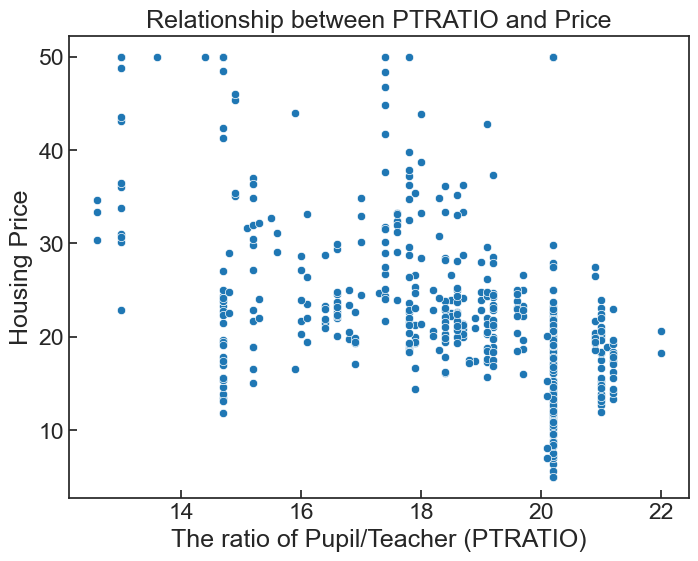

In [6]:
# your turn: scatter plot between *PTRATIO* and *PRICE*
ax = sns.scatterplot(x=bos.PTRATIO, y=bos.PRICE)

ax.set_xlabel("The ratio of Pupil/Teacher (PTRATIO)")
ax.set_ylabel("Housing Price")
ax.set_title("Relationship between PTRATIO and Price");

**Exercise:** What are some other numeric variables of interest? Why do you think they are interesting? Plot scatterplots with these variables and *PRICE* (house price) and tell a story about what you see.

In [7]:
print(bos.columns)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'PRICE'],
      dtype='object')


In [8]:
print(type(bos.columns))

<class 'pandas.core.indexes.base.Index'>


In [9]:
col_names = bos.columns.drop('PRICE')

print(col_names)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


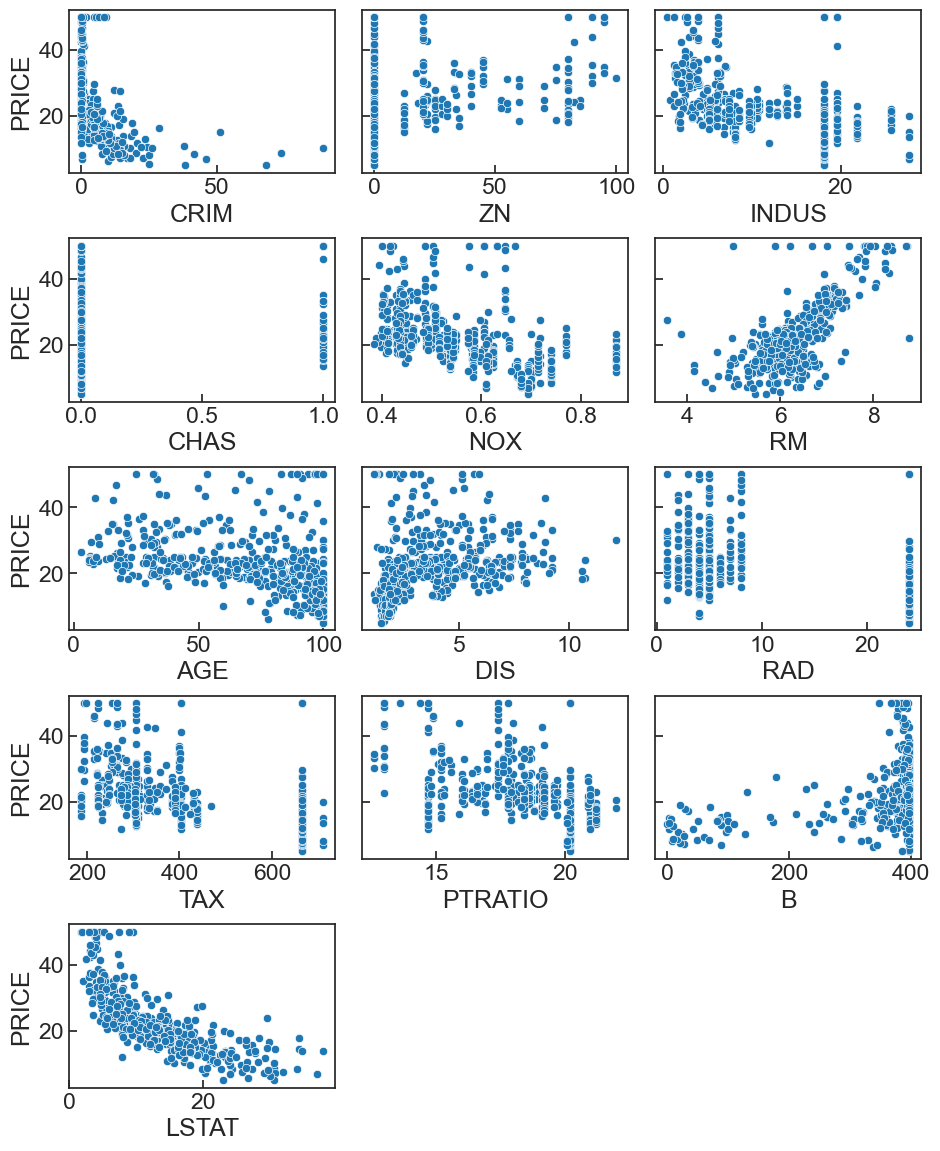

In [10]:
# your turn: create some other scatter plots

col_names = bos.columns.drop('PRICE')  # PRICE is set to independent variable
n_figs = len(col_names)            # number of figures
n_col = 3                          # number of cols
n_row = int(np.ceil(n_figs/n_col)) # number of rows

fig, axes = plt.subplots(n_row, n_col, sharey=True, figsize=(11,14))

for i, ax in enumerate(axes.flat):
    if i < n_figs:
        sns.scatterplot(x=bos[col_names[i]], y=bos['PRICE'], ax=ax)
    else:
        fig.delaxes(ax)      # delete redundant axes
        
    plt.subplots_adjust(wspace=.1, hspace=0.4)   # adjust gap between figures

### Scatterplots using Seaborn
***

[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) is a cool Python plotting library built on top of matplotlib. It provides convenient syntax and shortcuts for many common types of plots, along with better-looking defaults.

We can also use [seaborn regplot](https://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html#functions-to-draw-linear-regression-models) for the scatterplot above. This provides automatic linear regression fits (useful for data exploration later on). Here's one example below.

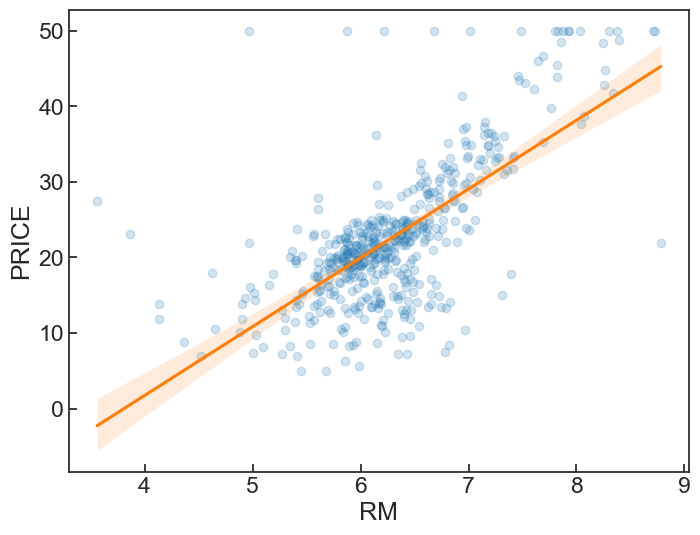

In [11]:
sns.regplot(y="PRICE", x="RM", data=bos, fit_reg = True, scatter_kws={'alpha':0.2}, line_kws={'color':'C1'});

### Histograms
***


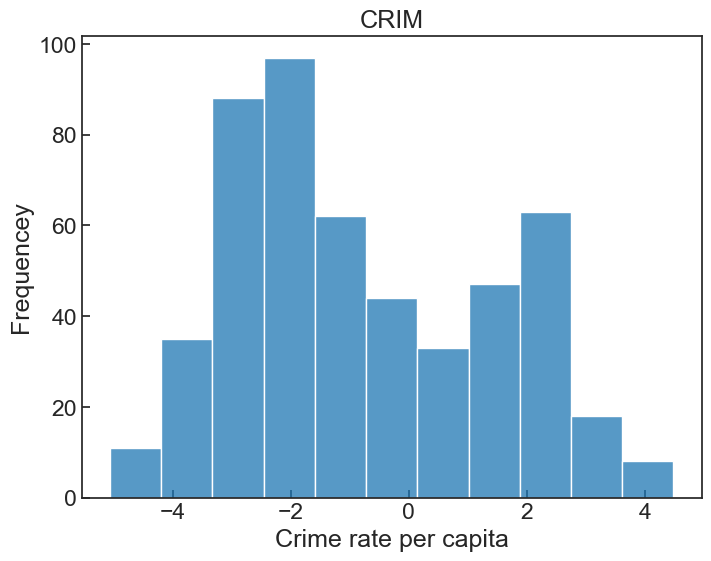

In [12]:
ax = sns.histplot(np.log(bos.CRIM))
ax.set_title("CRIM")
ax.set_xlabel("Crime rate per capita")
ax.set_ylabel("Frequencey");

<div class="span5 alert alert-info">
<h3>Part 2 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> In the above histogram, we took the logarithm of the crime rate per capita. Repeat this histogram without taking the log. What was the purpose of taking the log? What do we gain by making this transformation? What do you now notice about this variable that is not obvious without making the transformation?

<p><b>Exercise:</b> Plot the histogram for *RM* and *PTRATIO* against each other, along with the two variables you picked in the previous section. We are looking for correlations in predictors here.</p>
</div>

**Exercise:** In the above histogram, we took the logarithm of the crime rate per capita. Repeat this histogram without taking the log. What was the purpose of taking the log? What do we gain by making this transformation? What do you now notice about this variable that is not obvious without making the transformation?

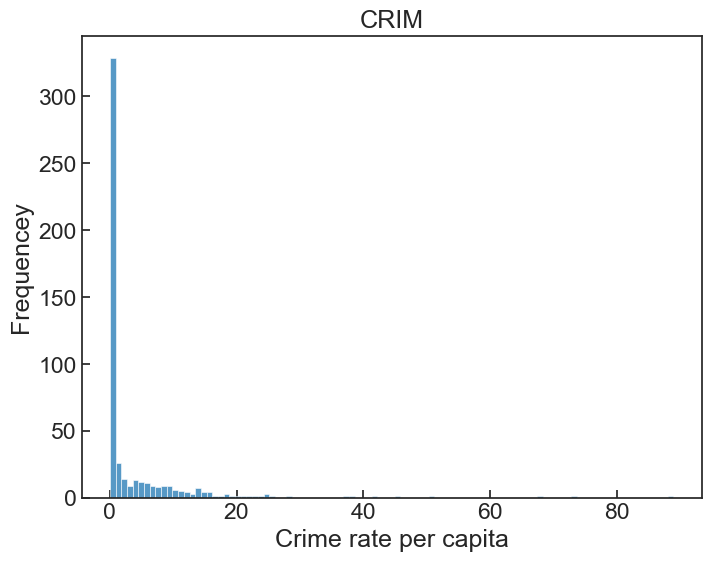

In [13]:
#your turn
ax = sns.histplot(bos.CRIM)
ax.set_title("CRIM")
ax.set_xlabel("Crime rate per capita")
ax.set_ylabel("Frequencey");

**Exercise:** Plot the histogram for *RM* and *PTRATIO* against each other, along with the two variables you picked in the previous section. We are looking for correlations in predictors here.

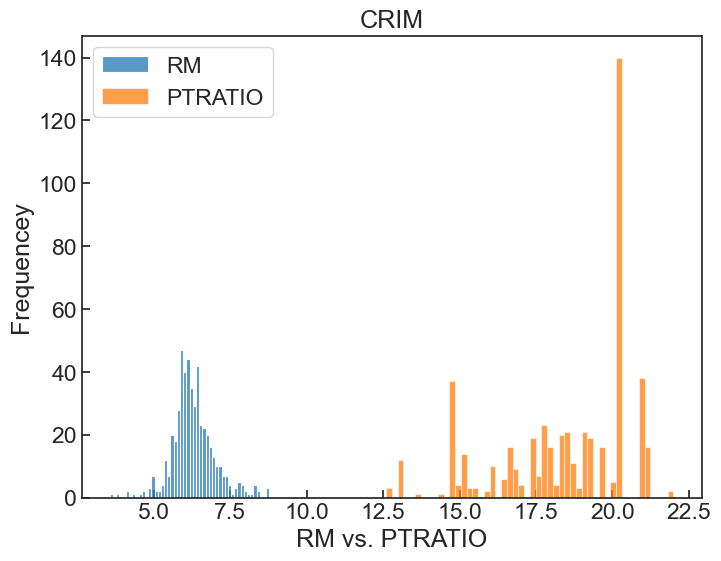

In [14]:
fig, ax = plt.subplots()

sns.histplot(bos.RM, bins=50, color='C0', label="RM", ax=ax)
sns.histplot(bos.PTRATIO, bins=50, color='C1', label="PTRATIO", ax=ax)
ax.set_title("CRIM")
ax.set_xlabel("RM vs. PTRATIO")
ax.set_ylabel("Frequencey")
ax.legend(loc='upper left');

## Part 3: Linear Regression with Boston Housing Data Example
***

Here, 

$Y$ = boston housing prices (called "target" data in python, and referred to as the dependent variable or response variable)

and

$X$ = all the other features (or independent variables, predictors or explanatory variables)

which we will use to fit a linear regression model and predict Boston housing prices. We will use the least-squares method to estimate the coefficients.  

We'll use two ways of fitting a linear regression. We recommend the first but the second is also powerful in its features.

### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive workshop, it's a good library to have in your toolbox. Here's a quick example of what you could do with it. The version of least-squares we will use in statsmodels is called *ordinary least-squares (OLS)*. There are many other versions of least-squares such as [partial least squares (PLS)](https://en.wikipedia.org/wiki/Partial_least_squares_regression) and [weighted least squares (WLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).

In [15]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [16]:
# statsmodels works nicely with pandas dataframes
# The thing inside the "quotes" is called a formula, a bit on that below
m = ols('PRICE ~ RM',bos).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Sat, 06 Aug 2022   Prob (F-statistic):           2.49e-74
Time:                        02:35:45   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.000     -39.877     -29.465
RM             9.1021      0.419     21.722      0.000       8.279       9.925
==============================================================================
Omnibus:                      102.585   Durbin-Watson:                   0.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              612.449
Skew:                           0.726   Prob(JB):                    1.02e-133
Kurtosis:                       8.190   Cond. No.                         58.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpreting coefficients

There is a ton of information in this output. But we'll concentrate on the coefficient table (middle table). We can interpret the `RM` coefficient (9.1021) by first noticing that the p-value (under `P>|t|`) is so small, basically zero. This means that the number of rooms, `RM`, is a statisticall significant predictor of `PRICE`. The regression coefficient for `RM` of 9.1021 means that *on average, each additional room is associated with an increase of $\$9,100$ in house price net of the other variables*. The confidence interval gives us a range of plausible values for this average change, about ($\$8,279, \$9,925$), definitely not chump change. 

In general, the $\hat{\beta_i}, i > 0$ can be interpreted as the following: "A one unit increase in $x_i$ is associated with, on average, a $\hat{\beta_i}$ increase/decrease in $y$ net of all other variables."

On the other hand, the interpretation for the intercept, $\hat{\beta}_0$ is the average of $y$ given that all of the independent variables $x_i$ are 0.

####  `statsmodels` formulas
***
This formula notation will seem familiar to `R` users, but will take some getting used to for people coming from other languages or are new to statistics.

The formula gives instruction for a general structure for a regression call. For `statsmodels` (`ols` or `logit`) calls you need to have a Pandas dataframe with column names that you will add to your formula. In the below example you need a pandas data frame that includes the columns named (`Outcome`, `X1`,`X2`, ...), but you don't need to build a new dataframe for every regression. Use the same dataframe with all these things in it. The structure is very simple:

`Outcome ~ X1`

But of course we want to to be able to handle more complex models, for example multiple regression is doone like this:

`Outcome ~ X1 + X2 + X3`

In general, a formula for an OLS multiple linear regression is

`Y ~ X1 + X2 + ... + Xp`

This is the very basic structure but it should be enough to get you through the homework. Things can get much more complex. You can force statsmodels to treat variables as categorical with the `C()` function, call numpy functions to transform data such as `np.log` for extremely-skewed data, or fit a model without an intercept by including `- 1` in the formula. For a quick run-down of further uses see the `statsmodels` [help page](http://statsmodels.sourceforge.net/devel/example_formulas.html).


Let's see how our model actually fit our data. We can see below that there is a ***ceiling effect***, we should probably look into that. Also, for large values of $Y$ we get underpredictions, most predictions are below the 45-degree gridlines. 

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a scatterplot between the predicted prices, available in `m.fittedvalues` (where `m` is the fitted model) and the original prices. How does the plot look? Do you notice anything interesting or weird in the plot? Comment on what you see.</p>
</div>

Text(0, 0.5, 'Predicted Price')

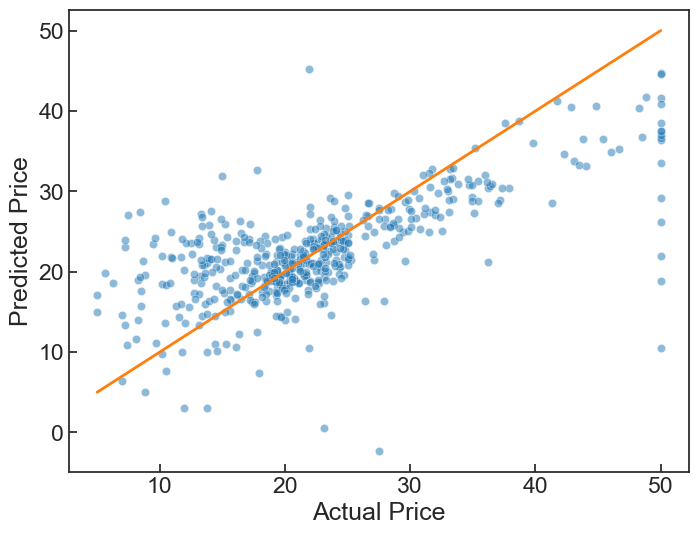

In [17]:
# your turn
fig, ax = plt.subplots()

sns.scatterplot(x=bos.PRICE, y=m.fittedvalues, alpha=0.5, ax=ax)
ax.plot([5,50],[5,50],linewidth=2, color='C1')

ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')

> The predicted price seems to be well fitted for the actual price between \\$20,000 - \\$30,000, but it spreads out for the lower actual prices. Moreover, when the actual price is \\$50,000, the prediction goes very weirdly.

### Fitting Linear Regression using `sklearn`


In [18]:
from sklearn.linear_model import LinearRegression
X = bos.drop('PRICE', axis = 1)

# This creates a LinearRegression object
lm = LinearRegression()
lm

LinearRegression()

In [19]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


#### What can you do with a LinearRegression object? 
***
Check out the scikit-learn [docs here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). We have listed the main functions here. Most machine learning models in scikit-learn follow this same API of fitting a model with `fit`, making predictions with `predict` and the appropriate scoring function `score` for each model.

Main functions | Description
--- | --- 
`lm.fit()` | Fit a linear model
`lm.predit()` | Predict Y using the linear model with estimated coefficients
`lm.score()` | Returns the coefficient of determination (R^2). *A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model*

#### What output can you get?

In [20]:
# Look inside lm object
# lm.<tab>

Output | Description
--- | --- 
`lm.coef_` | Estimated coefficients
`lm.intercept_` | Estimated intercept 

### Fit a linear model
***

The `lm.fit()` function estimates the coefficients the linear regression using least squares. 

In [21]:
# Use all 13 predictors to fit linear regression model
lm.fit(X, bos.PRICE)

LinearRegression()

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> How would you change the model to not fit an intercept term? Would you recommend not having an intercept? Why or why not? For more information on why to include or exclude an intercept, look [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-is-regression-through-the-origin/).</p>

<p><b>Exercise:</b> One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it enough that the residuals are normally distributed? Explain your answer.</p>

<p><b>Exercise:</b> True or false. To use linear regression, $Y$ must be normally distributed. Explain your answer.</p>
</div>


**Exercise:** How would you change the model to not fit an intercept term? Would you recommend not having an intercept? Why or why not? For more information on why to include or exclude an intercept, look [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-is-regression-through-the-origin/).

> A) We can do change the model to not fit an intercept term by setting the keyword "fit_intercept=False". I recommend to not removing intercept because it may cause unintentional bias to the regression with other parameters. It would be removed only when our target goes through the origin

In [22]:
# your turn
lm_nointercept = LinearRegression(fit_intercept=False)
lm_nointercept.fit(X, bos.PRICE)

# print R-squared coefficient for the model w/ and w/o fitting an intercept
print("score (w/  intercept): {:f}".format(lm.score(X, bos.PRICE)))
print("score (w/o intercept): {:f}".format(lm_nointercept.score(X, bos.PRICE)))

score (w/  intercept): 0.740643
score (w/o intercept): 0.713738


**Exercise:** One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it enough that the residuals are normally distributed? Explain your answer.

> A) In order to obey the assumption of the linear model that the residuals must be i.i.d, it is enough to get a normal distribution for the residuals. It is because that the residual at each prediction is not affected by other predctions and it is re-centered at the Y value (i.e., mean=0). 

**Exercise:** True or false. To use linear regression,  𝑌  must be normally distributed. Explain your answer.

> A) False. Y is not necessarily to be normally distributed, since Linear regression analysis, which includes t-test and ANOVA, does not assume normality for either predictors or an outcome.

### Estimated intercept and coefficients

Let's look at the estimated coefficients from the linear model using `1m.intercept_` and `lm.coef_`.  

After we have fit our linear regression model using the least squares method, we want to see what are the estimates of our coefficients $\beta_0$, $\beta_1$, ..., $\beta_{13}$: 

$$ \hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{13} $$



In [23]:
print('Estimated intercept coefficient: {}'.format(lm.intercept_))

Estimated intercept coefficient: 36.45948838509015


In [24]:
print('Number of coefficients: {}'.format(len(lm.coef_)))

Number of coefficients: 13


In [25]:
# The coefficients
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,CRIM,-0.108011
1,ZN,0.046420
2,INDUS,0.020559
3,CHAS,2.686734
4,NOX,-17.766611
5,RM,3.809865
6,AGE,0.000692
7,DIS,-1.475567
8,RAD,0.306049
9,TAX,-0.012335


### Predict Prices 

We can calculate the predicted prices ($\hat{Y}_i$) using `lm.predict`. 

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_1 + \ldots \hat{\beta}_{13} X_{13} $$

In [26]:
# first five predicted prices
lm.predict(X)[0:5]

array([30.00384338, 25.02556238, 30.56759672, 28.60703649, 27.94352423])

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Histogram: Plot a histogram of all the predicted prices. Write a story about what you see. Describe the shape, center and spread of the distribution. Are there any outliers? What might be the reason for them? Should we do anything special with them?</p>

<p><b>Exercise:</b> Scatterplot: Let's plot the true prices compared to the predicted prices to see they disagree (we did this with `statsmodels` before).</p>

<p><b>Exercise:</b> We have looked at fitting a linear model in both `statsmodels` and `scikit-learn`. What are the advantages and disadvantages of each based on your exploration? Based on the information provided by both packages, what advantage does `statsmodels` provide?</p>
</div>

**Exercise:** Histogram: Plot a histogram of all the predicted prices. Write a story about what you see. Describe the shape, center and spread of the distribution. Are there any outliers? What might be the reason for them? Should we do anything special with them?

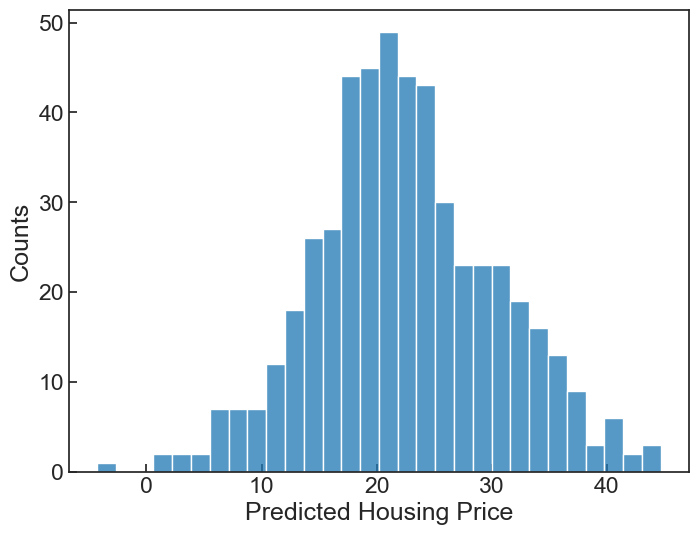

In [27]:
# your turn
ax = sns.histplot(x=lm.predict(X), bins=30)
ax.set_xlabel("Predicted Housing Price")
ax.set_ylabel("Counts");

**Exercise:** Scatterplot: Let's plot the true prices compared to the predicted prices to see they disagree (we did this with `statsmodels` before).

Text(0, 0.5, 'Predicted Housing Price')

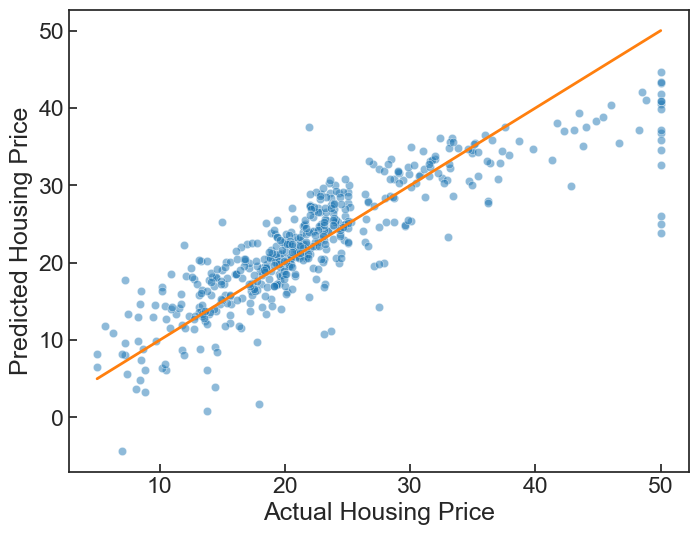

In [28]:
''' scatter plot '''
fig, ax = plt.subplots()

sns.scatterplot(x=bos.PRICE, y=lm.predict(X), alpha=0.5, ax=ax)
ax.plot([5,50], [5,50], lw=2, color='C1')
ax.set_xlabel('Actual Housing Price')
ax.set_ylabel('Predicted Housing Price')

> A) From the scatterplot, we can see that the predicted price is well consistent with the actual values when the actual housing price is under \\$35,000, but otherwise the predicted price is underestimated.

**Exercise:** We have looked at fitting a linear model in both `statsmodels` and `scikit-learn`. What are the advantages and disadvantages of each based on your exploration? Based on the information provided by both packages, what advantage does `statsmodels` provide?

> A) Both `statsmodels` and `scikit-learn` are quite powerful to compute statstics. Based on my brief experience of both packages, I learned that `statsmodels` provides well-designed statstics summary report, from which we can check if the model is statistcally significant. However, at this moment, I lean to use `scikit-learn` as it seems to contain lots of useful tools and actively being developed.

### Evaluating the Model: Sum-of-Squares

The partitioning of the sum-of-squares shows the variance in the predictions explained by the model and the variance that is attributed to error.

$$TSS = ESS + RSS$$

#### Residual Sum-of-Squares (aka $RSS$)

The residual sum-of-squares is one of the basic ways of quantifying how much error exists in the fitted model. We will revisit this in a bit.

$$ RSS = \sum_{i=1}^N r_i^2 = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

In [29]:
print(np.sum((bos.PRICE - lm.predict(X)) ** 2))

11078.784577954977


#### Explained Sum-of-Squares (aka $ESS$)

The explained sum-of-squares measures the variance explained by the regression model.

$$ESS = \sum_{i=1}^N \left( \hat{y}_i - \bar{y} \right)^2 = \sum_{i=1}^N \left( \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) - \bar{y} \right)^2$$

In [30]:
print(np.sum((lm.predict(X) - np.mean(bos.PRICE)) ** 2))

31637.510837065056


### Evaluating the Model: The Coefficient of Determination ($R^2$)

The coefficient of determination, $R^2$, tells us the **percentage of the variance in the response variable $Y$ that can be explained by the linear regression model.**

$$ R^2 = \frac{ESS}{TSS} $$

The $R^2$ value is one of the most common metrics that people use in describing the quality of a model, but it is important to note that **$R^2$ increases artificially as a side-effect of increasing the number of independent variables.** While $R^2$ is reported in almost all statistical packages, another metric called the ***adjusted $R^2$*** is also provided as it takes into account the number of variables in the model, and can sometimes even be used for non-linear regression models!

$$R_{adj}^2 = 1 - \left( 1 - R^2 \right) \frac{N - 1}{N - K - 1} = R^2 - \left( 1 - R^2 \right) \frac{K}{N - K - 1} = 1 - \frac{\frac{RSS}{DF_R}}{\frac{TSS}{DF_T}}$$

where $N$ is the number of observations, $K$ is the number of variables, $DF_R = N - K - 1$ is the degrees of freedom associated with the residual error and $DF_T = N - 1$ is the degrees of the freedom of the total error.

### Evaluating the Model: Mean Squared Error and the $F$-Statistic
***
The **mean squared errors are just the *averages* of the sum-of-squares errors over their respective degrees of freedom.**

$$MSE = \frac{RSS}{N-K-1}$$

$$MSR = \frac{ESS}{K}$$

**Remember:** Notation may vary across resources particularly the use of $R$ and $E$ in $RSS/ESS$ and $MSR/MSE$. In some resources, E = explained and R = residual. In other resources, E = error and R = regression (explained). **This is a very important distinction that requires looking at the formula to determine which naming scheme is being used.**

Given the MSR and MSE, we can now determine whether or not the entire model we just fit is even statistically significant. We use an $F$-test for this. The null hypothesis is that all of the $\beta$ coefficients are zero, that is, none of them have any effect on $Y$. The alternative is that *at least one* $\beta$ coefficient is nonzero, but it doesn't tell us which one in a multiple regression:

$$H_0: \beta_i = 0, \mbox{for all $i$} \\
H_A: \beta_i > 0, \mbox{for some $i$}$$ 

$$F = \frac{MSR}{MSE} = \left( \frac{R^2}{1 - R^2} \right) \left( \frac{N - K - 1}{K} \right)$$
 
Once we compute the $F$-statistic, we can use the $F$-distribution with $N-K$ and $K-1$ degrees of degrees of freedom to get a p-value.

**Warning!** The $F$-statistic mentioned in this section is NOT the same as the F1-measure or F1-value discused in Unit 7.

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set IV</h3>

<p>Let's look at the relationship between `PTRATIO` and housing price.</p>

<p><b>Exercise:</b> Try fitting a linear regression model using only the 'PTRATIO' (pupil-teacher ratio by town) and interpret the intercept and the coefficients.</p>

<p><b>Exercise:</b> Calculate (or extract) the $R^2$ value. What does it tell you?</p>

<p><b>Exercise:</b> Compute the $F$-statistic. What does it tell you?</p>

<p><b>Exercise:</b> Take a close look at the $F$-statistic and the $t$-statistic for the regression coefficient. What relationship do you notice? Note that this relationship only applies in *simple* linear regression models.</p>
</div>

**Exercise**: Try fitting a linear regression model using only the 'PTRATIO' (pupil-teacher ratio by town) and interpret the intercept and the coefficients.

In [31]:
# your turn
lm = LinearRegression()

lm.fit(X[['PTRATIO']], bos.PRICE)

print("PTRATIO vs. PRICE -- intercept:   {}".format(lm.intercept_))
print("PTRATIO vs. PRICE -- coefficient: {}".format(lm.coef_[0]))

PTRATIO vs. PRICE -- intercept:   62.34462747483266
PTRATIO vs. PRICE -- coefficient: -2.1571752960609656


> A) In this model, the price value when PTRATIO is zero (intercept) is \\$62,345, and the price would decrease by \\$2,157 as the ratio would increase by 1.

**Exercise:** Calculate (or extract) the  𝑅2  value. What does it tell you?

In [32]:
r_sq = lm.score(X[['PTRATIO']], bos.PRICE)
print("R-squared: {}".format(r_sq))

R-squared: 0.257847318009223


> A) $R^2$ value seems not high enough to consider that `PTRATIO` is a good predictor.

**Exercise:** Compute the  𝐹 -statistic. What does it tell you?

In [33]:
def calc_F(X,y):
    ''' calculate the F-statistics '''
    N = y.count()
    K = np.shape(X)[1]
    
    print("N: {:d}, K: {:d}".format(N, K))
    
    r_sq = lm.score(X, y)
    
    F = (r_sq)/(1-r_sq) * (N-K-1)/K
    
    return F

In [34]:
print("F-statistic: {}".format(calc_F(X[['PTRATIO']], bos.PRICE)))

N: 506, K: 1
F-statistic: 175.10554287569548


> A) The F-statistic seems very high, so we can think that the null hypothesis can be rejected.

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set V</h3>

<p>Fit a linear regression model using three independent variables</p>

<ol>
<li> 'CRIM' (per capita crime rate by town)
<li> 'RM' (average number of rooms per dwelling)
<li> 'PTRATIO' (pupil-teacher ratio by town)
</ol>

<p><b>Exercise:</b> Compute or extract the $F$-statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Compute or extract the $R^2$ statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Which variables in the model are significant in predicting house price? Write a story that interprets the coefficients.</p>
</div>

In [35]:
lm = LinearRegression()
lm.fit(X[['CRIM','RM','PTRATIO']], bos.PRICE)

LinearRegression()

**Exercise:** Compute or extract the  𝐹 -statistic. What does it tell you about the model?

In [36]:
print("F-statistic: {}".format(calc_F(X[['CRIM','RM','PTRATIO']], bos.PRICE)))

N: 506, K: 3
F-statistic: 245.16449030064624


> A) The F-statistic seems very high, it means the regression results are statistically significant.

**Exercise:** Compute or extract the  𝑅2  statistic. What does it tell you about the model?

In [37]:
print("R-squared: {}".format(lm.score(X[['CRIM','RM','PTRATIO']], bos.PRICE)))

R-squared: 0.5943412940723471


> A) The $R^2$ value is higher than that for `PTRATIO` as a single predictor. This means that using multiple parameters `CRIM`, `RM`, and `PTRATIO` is better to describe the observation than using `PTRATIO` alone. 

## Part 4: Comparing Models

During modeling, there will be times when we want to compare models to see which one is more predictive or fits the data better. There are many ways to compare models, but we will focus on two.

### The $F$-Statistic Revisited

The $F$-statistic can also be used to compare two ***nested*** models, that is, **two models trained on the same dataset where one of the models contains a *subset* of the variables of the other model.** The *full* model contains $K$ variables and the *reduced* model contains a subset of these $K$ variables. This allows us to add additional variables to a base model and then test if adding the variables helped the model fit.

$$F = \frac{\left( \frac{RSS_{reduced} - RSS_{full}}{DF_{reduced} - DF_{full}} \right)}{\left( \frac{RSS_{full}}{DF_{full}} \right)}$$

where $DF_x = N - K_x - 1$ where $K_x$ is the number of variables in model $x$.

### Akaike Information Criterion (AIC)

Another statistic for comparing two models is AIC, which is based on the likelihood function and takes into account the number of variables in the model.

$$AIC = 2 K - 2 \log_e{L}$$

where $L$ is the likelihood of the model. AIC is meaningless in the absolute sense, and is only meaningful when compared to AIC values from other models. Lower values of AIC indicate better fitting models.

`statsmodels` provides the AIC in its output.

<div class="span5 alert alert-info">
<h3>Part 4 Checkup Exercises</h3>

<p><b>Exercise:</b> Find another variable (or two) to add to the model we built in Part 3. Compute the $F$-test comparing the two models as well as the AIC. Which model is better?</p>
</div>

In [38]:
def calc_F2(X_full, X_reduced, y):
    ''' function for computing F-statistic to compare two nested models '''
    
    # check the subset(X_reduced) is included in the full set (X_full)
    for icol in X_reduced.columns.values:
        if (icol not in X_full.columns.values):
            raise ValueError('X_reduced parameters should be a subset of X_full')
    
    # build up the model
    lm_full = LinearRegression()
    lm_full.fit(X_full, y)
    
    lm_reduced = LinearRegression()
    lm_reduced.fit(X_reduced, y)
    
    # compute F-statistic
    RSS_full = np.sum( (y - lm_full.predict(X_full))**2 )
    RSS_reduced = np.sum( (y - lm_reduced.predict(X_reduced))**2 )
   
    N          = y.count()
    K_full     = np.shape(X_full)[1]  # number of variables
    K_reduced  = np.shape(X_reduced)[1]
    DF_full    = N - K_full - 1       # degree of fredoom
    DF_reduced = N - K_reduced - 1
    
    print("N: {:d}, K_full: {:d}, K_reduced: {:d}".format(N, K_full, K_reduced))

    F = ( (RSS_reduced - RSS_full) / (DF_reduced - DF_full) ) / \
        ( RSS_full / DF_full )
    
    return F

In [39]:
X_reduced = X[['CRIM','RM','PTRATIO']]  # the same model as we did in previous section
X_added = X[['CRIM','RM','PTRATIO','LSTAT','NOX']]  # two more variables added 

print("F-statistics comparison of nested datsetset: {}".format(calc_F2(X_added, X_reduced, bos.PRICE)))

N: 506, K_full: 5, K_reduced: 3
F-statistics comparison of nested datsetset: 68.57580902736834


In [40]:
''' compute AIC values '''

m_reduced = sm.OLS(bos.PRICE, X_reduced, hasconst=True).fit()
m_added   = sm.OLS(bos.PRICE, X_added, hasconst=True).fit()

print("AIC w/ full variable: {}".format(m_added.aic))
print("AIC w/ reduced variable: {}".format(m_reduced.aic))

AIC w/ full variable: 3129.1967748497054
AIC w/ reduced variable: 3230.648445108978


> A) The model with two additional variables (`LSTAT` and `NOX`) has a lower AIC value than the model with only three variables (`CRIM`,`RM`,`PTRATIO`). This indicates that the model with the additional variables presents better fit.


## Part 5: Evaluating the Model via Model Assumptions and Other Issues
***
Linear regression makes several assumptions. It is always best to check that these assumptions are valid after fitting a linear regression model.

<div class="span5 alert alert-danger">
<ul>
  <li>**Linearity**. The dependent variable $Y$ is a linear combination of the regression coefficients and the independent variables $X$. This can be verified with a scatterplot of each $X$ vs. $Y$ and plotting correlations among $X$. Nonlinearity can sometimes be resolved by [transforming](https://onlinecourses.science.psu.edu/stat501/node/318) one or more independent variables, the dependent variable, or both. In other cases, a [generalized linear model](https://en.wikipedia.org/wiki/Generalized_linear_model) or a [nonlinear model](https://en.wikipedia.org/wiki/Nonlinear_regression) may be warranted.</li>
  <li>**Constant standard deviation**. The SD of the dependent variable $Y$ should be constant for different values of X. We can check this by plotting each $X$ against $Y$ and verifying that there is no "funnel" shape showing data points fanning out as $X$ increases or decreases. Some techniques for dealing with non-constant variance include weighted least squares (WLS), [robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors), or variance stabilizing transformations.
    </li>
  <li> **Normal distribution for errors**.  The $\epsilon$ term we discussed at the beginning are assumed to be normally distributed. This can be verified with a fitted values vs. residuals plot and verifying that there is no pattern, and with a quantile plot.
  $$ \epsilon_i \sim N(0, \sigma^2)$$
Sometimes the distributions of responses $Y$ may not be normally distributed at any given value of $X$.  e.g. skewed positively or negatively. </li>
<li> **Independent errors**.  The observations are assumed to be obtained independently.
    <ul>
        <li>e.g. Observations across time may be correlated
    </ul>
</li>
</ul>  

</div>

There are some other issues that are important investigate with linear regression models.

<div class="span5 alert alert-danger">
<ul>
  <li>**Correlated Predictors:** Care should be taken to make sure that the independent variables in a regression model are not too highly correlated. Correlated predictors typically do not majorly affect prediction, but do inflate standard errors of coefficients making interpretation unreliable. Common solutions are dropping the least important variables involved in the correlations, using regularlization, or, when many predictors are highly correlated, considering a dimension reduction technique such as principal component analysis (PCA).
  <li>**Influential Points:** Data points that have undue influence on the regression model. These points can be high leverage points or outliers. Such points are typically removed and the regression model rerun.
</ul>
</div>


<div class="span5 alert alert-info">
<h3>Part 5 Checkup Exercises</h3>

<p>Take the reduced model from Part 3 to answer the following exercises. Take a look at [this blog post](http://mpastell.com/2013/04/19/python_regression/) for more information on using statsmodels to construct these plots.</p>
    
<p><b>Exercise:</b> Construct a fitted values versus residuals plot. What does the plot tell you? Are there any violations of the model assumptions?</p>

<p><b>Exercise:</b> Construct a quantile plot of the residuals. What does the plot tell you?</p>

<p><b>Exercise:</b> What are some advantages and disadvantages of the fitted vs. residual and quantile plot compared to each other?</p>

<p><b>Exercise:</b> Identify any outliers (if any) in your model and write a story describing what these outliers might represent.</p>

<p><b>Exercise:</b> Construct a leverage plot and identify high leverage points in the model. Write a story explaining possible reasons for the high leverage points.</p>

<p><b>Exercise:</b> Remove the outliers and high leverage points from your model and run the regression again. How do the results change?</p>
</div>

**Exercise:** Construct a fitted values versus residuals plot. What does the plot tell you? Are there any violations of the model assumptions?

In [41]:
lm_reduced = LinearRegression()
lm_reduced.fit(X[['CRIM','RM','PTRATIO']], bos.PRICE)  # fitting the model
y_pred_reduced = lm_reduced.predict(X[['CRIM','RM','PTRATIO']])   # predicted values

res_reduced = bos.PRICE - y_pred_reduced  # residuals

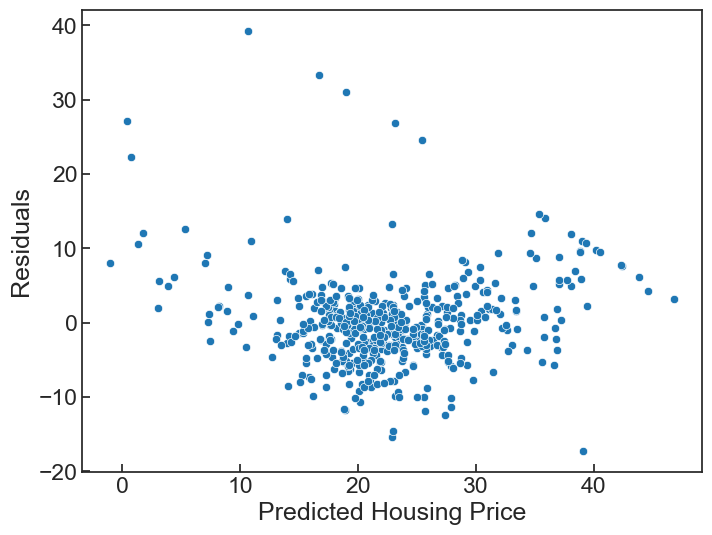

In [42]:
ax = sns.scatterplot(x=y_pred_reduced, y=res_reduced)
ax.set_xlabel('Predicted Housing Price')
ax.set_ylabel('Residuals');

> A) There are some outliers, but it seems that there is no apparent patterns.

**Exercise:** Construct a quantile plot of the residuals. What does the plot tell you?

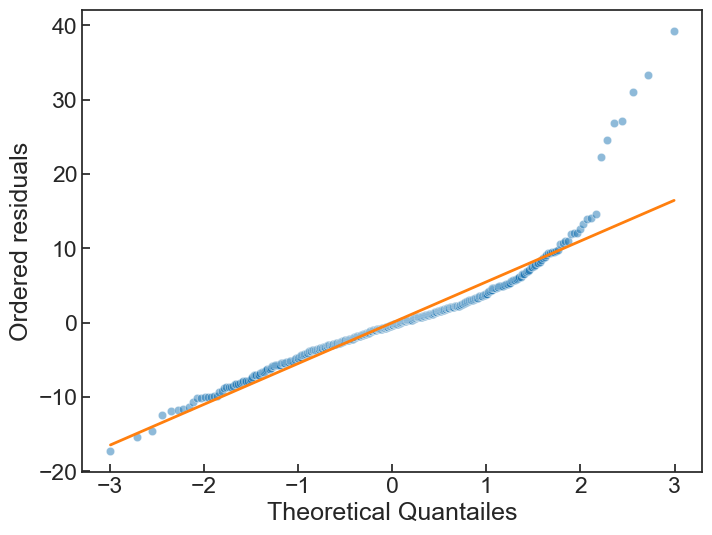

In [43]:
# compare the distribution of residuals to normal distribution
results = stats.probplot(res_reduced, dist="norm", plot=None)  # we will plot the results below.

# unpack the results
x_res, y_res = results[0]   # x: theoretical quantailes. y: ordered responses (sorted input)
slope, intercept, sqr_det = results[1]  # slope, intercept and the square root of the coefficient of determination (least-square fit)

fig, ax = plt.subplots()
sns.scatterplot(x=x_res, y=y_res, alpha=0.5, ax=ax)
ax.plot([np.min(x_res), np.max(x_res)], \
        [np.min(x_res)*slope+intercept, np.max(x_res)*slope+intercept], color='C1', lw=2)
ax.set_xlabel('Theoretical Quantailes')
ax.set_ylabel('Ordered residuals');

> The quantile plot shows that the distribution of residuals seems a bit skewed.

<div class="alert alert-warning">
Note: probplot generates a probability plot, which should not be confused with a Q-Q or a P-P plot. Statsmodels has more extensive functionality of this type, see statsmodels.api.ProbPlot.
<\div>

**Exercise:** What are some advantages and disadvantages of the fitted vs. residual and quantile plot compared to each other?

> The plot of the fitted vs. residual shows the relationship between the fitted values and residuals intuitively, and also it is easy to check whether there is outliers. The quantile plot, however, tells us how the residuals are distributed. 

**Exercise:** Identify any outliers (if any) in your model and write a story describing what these outliers might represent.

> There are some outliers as we see in the fitted vs. residual plot. It tells that some of places has some different housing prices from the expected values using the model with the number of rooms, crime rates, and pupil-teacher ratio.

**Exercise:** Construct a leverage plot and identify high leverage points in the model. Write a story explaining possible reasons for the high leverage points.

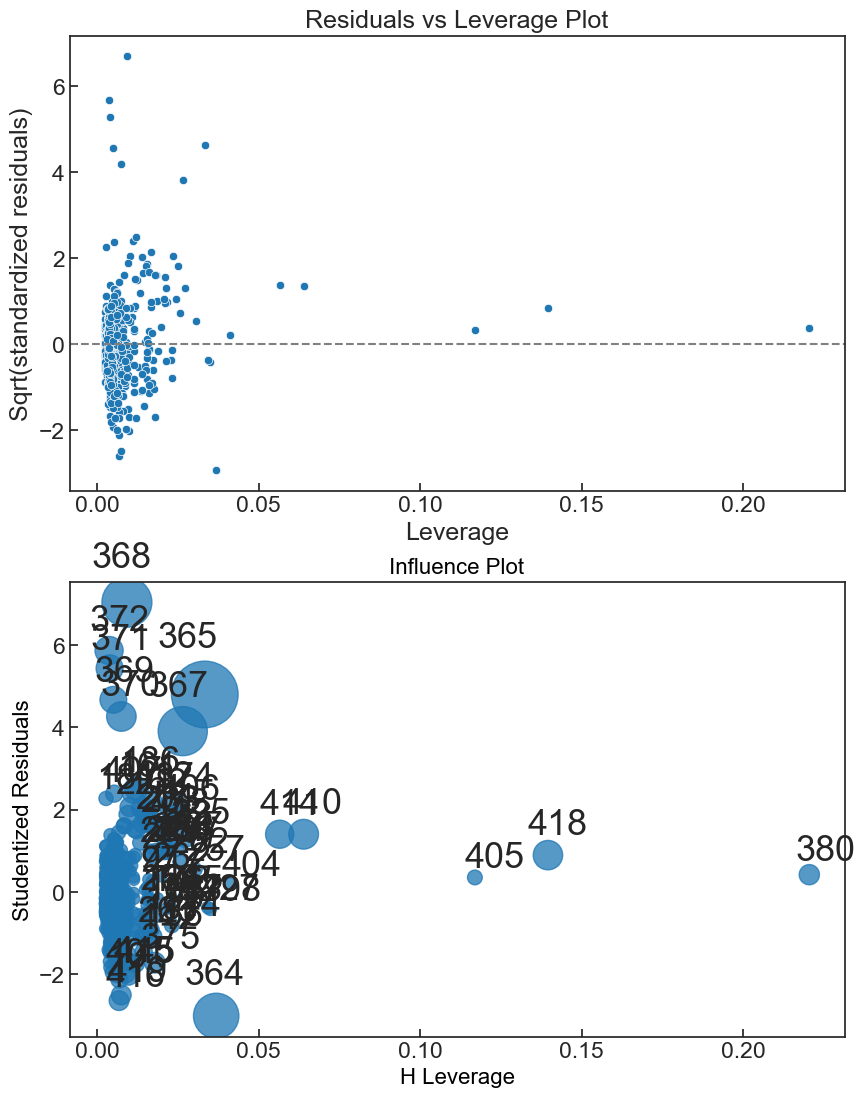

In [44]:
m_reduced = ols('PRICE ~ CRIM + RM + PTRATIO', bos).fit()

stand_resids = m_reduced.resid_pearson  # square root of standardized residuals
influence = m_reduced.get_influence()   # get influence
leverage = influence.hat_matrix_diag    # get leverage

fig, axes = plt.subplots(2,1, figsize=(10,13))
# Residual vs Leverage Plot
sns.scatterplot(x=leverage, y=stand_resids, ax=axes[0])
axes[0].axhline(y=0, color='grey', linestyle='dashed')
axes[0].set_xlabel('Leverage')
axes[0].set_ylabel('Sqrt(standardized residuals)')
axes[0].set_title('Residuals vs Leverage Plot')

# PLot Cook's distance plot
gg = sm.graphics.influence_plot(m_reduced, criterion="cooks", ax=axes[1])

> A) The points with high leverage values indicate the outliers. 

<div class="alert alert-info">
- Outliers: Outliers are the points that are distinct and deviant from the bulk of the dataset. In general, the outliers have high residual values means that the difference is greater than the b/w observed and predicted value. </br>
- Leverage Points: A leverage point is defined as an observation that has a value of x that is far away from the mean of x. </br>
- Influential Points: An influential observation is defined as an observation that has a large influence on the fit of the model. One method to find influential points is to compare the fit of the model with and without each observation.
<\div>

**Exercise:** Remove the outliers and high leverage points from your model and run the regression again. How do the results change?

In [45]:
# check the influence parameter
inf_sum = influence.summary_frame()

inf_sum.head(3)

,dfb_Intercept,dfb_CRIM,dfb_RM,dfb_PTRATIO,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.035140,0.000412,0.004115,0.049678,0.001045,-0.817854,0.006208,-0.064642,-0.817584,-0.064621
1,-0.003705,0.008572,-0.001235,0.004238,0.000199,-0.575202,0.002397,-0.028193,-0.574819,-0.028174
2,-0.025394,-0.005671,0.037987,0.006262,0.000653,0.697322,0.005347,0.051126,0.696965,0.051100


In [46]:
bos_inf = pd.concat([bos, inf_sum], axis = 1)
bos_inf.rename(columns={'hat_diag': 'leverage'}, inplace=True)

bos_inf.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,dfb_Intercept,dfb_CRIM,dfb_RM,dfb_PTRATIO,cooks_d,standard_resid,leverage,dffits_internal,student_resid,dffits
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,...,-0.035140,0.000412,0.004115,0.049678,0.001045,-0.817854,0.006208,-0.064642,-0.817584,-0.064621
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,...,-0.003705,0.008572,-0.001235,0.004238,0.000199,-0.575202,0.002397,-0.028193,-0.574819,-0.028174
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,...,-0.025394,-0.005671,0.037987,0.006262,0.000653,0.697322,0.005347,0.051126,0.696965,0.051100


In [47]:
#studentized residuals for identifying outliers
#requested studentized residuals call them r
#studentized residuals that exceed +2 or -2 are concerning
#studentized residuals that exceed +3 or -3 are extremely concerning

r = bos_inf.student_resid
print ('-'*30 + ' studentized residual ' + '-'*30)
print (r.describe())
print ('\n')

r_sort = bos_inf.sort_values(by = 'student_resid')
print ('-'*30 + ' top 5 most negative residuals ' + '-'*30)
print (r_sort[['CRIM','RM','PTRATIO','PRICE','student_resid']].head())
print ('\n')

print ('-'*30 + ' top 5 most positive residuals ' + '-'*30)
print (r_sort[['CRIM','RM','PTRATIO','PRICE','student_resid']].tail())

------------------------------ studentized residual ------------------------------
count    506.000000
mean       0.002723
std        1.014193
min       -3.008939
25%       -0.513541
50%       -0.057942
75%        0.375138
max        7.036931
Name: student_resid, dtype: float64


------------------------------ top 5 most negative residuals ------------------------------
         CRIM     RM  PTRATIO  PRICE  student_resid
364   3.47428  8.780     20.2   21.9      -3.008939
416  10.83420  6.782     20.2    7.5      -2.638321
419  11.81230  6.824     20.2    8.4      -2.501679
10    0.22489  6.377     15.2   15.0      -2.123635
145   2.37934  6.130     14.7   13.8      -2.035006


------------------------------ top 5 most positive residuals ------------------------------
        CRIM     RM  PTRATIO  PRICE  student_resid
369  5.66998  6.683     20.2   50.0       4.669117
365  4.55587  3.561     20.2   27.5       4.797961
371  9.23230  6.216     20.2   50.0       5.432903
372  8.26725  5.8

In [48]:
#Print values where the studentized residuals exceed 2
outliers_ind_r = abs(r) > 2
bos_inf.loc[outliers_ind_r, ['CRIM','RM','PTRATIO','PRICE','student_resid']]

,CRIM,RM,PTRATIO,PRICE,student_resid
10,0.22489,6.377,15.2,15.0,-2.123635
145,2.37934,6.130,14.7,13.8,-2.035006
161,1.46336,7.489,14.7,50.0,2.428598
162,1.83377,7.802,14.7,50.0,2.043854
181,0.06888,6.144,17.8,36.2,2.272291
186,0.05602,7.831,17.8,50.0,2.517580
228,0.29819,7.686,17.4,46.7,2.062123
364,3.47428,8.780,20.2,21.9,-3.008939
365,4.55587,3.561,20.2,27.5,4.797961
367,13.52220,3.863,20.2,23.1,3.907470


Now that we identified outliers, we need to see which observations can be considered to have leverage values. the leverage cutoff can be calculated as (2k+2)/n where k is the number of predictors and n is the sample size. See [this site](https://www.datasklr.com/ols-least-squares-regression/diagnostics-for-leverage-and-influence) for more information.

In [49]:
#Identify high leverage
#point with leverage = (2k+2)/n 

N = bos_inf.PRICE.count()
K = np.shape(X_reduced)[1]  # number of variables

l_crit = (2*K+2)/N

print("N: {:d} and K: {:d}".format(N, K))
print("leverage criteria: {}".format(l_crit))
    
l = bos_inf.leverage

print ('-'*30 + ' Leverage ' + '-'*30)
print (l.describe())
print ('\n')

l_sort = bos_inf.sort_values(by = 'leverage', ascending = False)
print ('-'*30 + ' top 5 highest leverage data points ' + '-'*30)
print (l_sort[['CRIM','RM','PTRATIO','PRICE','student_resid','leverage']].head())

N: 506 and K: 3
leverage criteria: 0.015810276679841896
------------------------------ Leverage ------------------------------
count    506.000000
mean       0.007905
std        0.013809
min        0.002283
25%        0.003461
50%        0.004867
75%        0.007531
max        0.220554
Name: leverage, dtype: float64


------------------------------ top 5 highest leverage data points ------------------------------
        CRIM     RM  PTRATIO  PRICE  student_resid  leverage
380  88.9762  6.968     20.2   10.4       0.420988  0.220554
418  73.5341  5.957     20.2    8.8       0.895644  0.139582
405  67.9208  5.683     20.2    5.0       0.353569  0.116949
410  51.1358  5.757     20.2   15.0       1.402952  0.063889
414  45.7461  4.519     20.2    7.0       1.403084  0.056465


In [50]:
#Print all values where the leverage exceeds l_crit
outliers_ind_l = abs(l) > l_crit 
bos_inf.loc[outliers_ind_l, ['CRIM','RM','PTRATIO','PRICE','student_resid','leverage']]

,CRIM,RM,PTRATIO,PRICE,student_resid,leverage
97,0.12083,8.069,18.0,38.7,0.307649,0.015835
142,3.32105,5.403,14.7,13.4,-1.150426,0.015980
144,2.77974,4.903,14.7,11.8,-0.813110,0.023068
147,2.36862,4.926,14.7,14.6,-0.374560,0.022679
148,2.33099,5.186,14.7,17.8,-0.155179,0.018719
151,1.49632,5.404,14.7,19.6,-0.151526,0.015862
152,1.12658,5.012,14.7,15.3,-0.406850,0.021323
156,2.44668,5.272,14.7,13.1,-1.067390,0.017554
163,1.51902,8.375,14.7,50.0,1.307334,0.021265
196,0.04011,7.287,12.6,33.3,-0.622189,0.017360


In [51]:
''' remove all outliers '''

bos_nooutliers = bos_inf.loc[(~outliers_ind_r) & (~outliers_ind_l)]
bos_nooutliers[['CRIM','RM','PTRATIO','PRICE','student_resid','leverage']].sample(5)

,CRIM,RM,PTRATIO,PRICE,student_resid,leverage
93,0.02875,6.211,18.2,25.0,0.340965,0.002408
111,0.10084,6.715,17.8,22.8,-0.737747,0.002877
1,0.02731,6.421,17.8,21.6,-0.574819,0.002397
172,0.13914,5.572,16.6,23.1,0.534410,0.007615
424,8.79212,5.565,20.2,11.7,-0.442261,0.004656


**Now we perform the Regression again with this dataset, in which all outliers were eliminated!**

In [52]:
lm_noout= LinearRegression()
lm_noout.fit(bos_nooutliers[['CRIM','RM','PTRATIO']], bos_nooutliers.PRICE)  # fitting the model
y_pred_noout = lm_noout.predict(bos_nooutliers[['CRIM','RM','PTRATIO']])   # predicted values

print("R^2 score from the data w/o outliers: {}". \
      format(lm_noout.score(bos_nooutliers[['CRIM','RM','PTRATIO']], bos_nooutliers.PRICE)))

res_noout = bos_nooutliers.PRICE - y_pred_noout  # residuals

R^2 score from the data w/o outliers: 0.7327506202675904


> A) The $R^2$ score is higher than the previous result (with outliers: $R^2\sim0.59$). Therefore, we can see the fitting has been improved after eliminating the outliers. The following plots show the residuals and influence plots, indicating how the residuals and influence factors are changed when we eliminate the outliers.

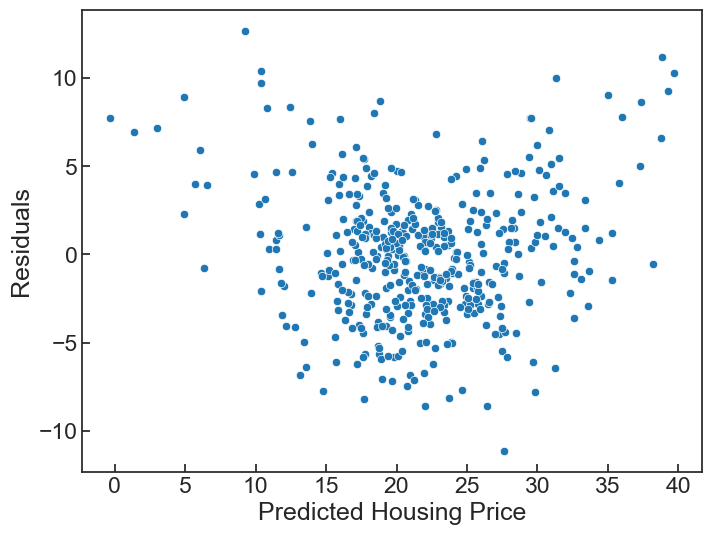

In [53]:
''' scatter plot of predicted value and residuals'''
ax = sns.scatterplot(x=y_pred_noout, y=res_noout)
ax.set_xlabel('Predicted Housing Price')
ax.set_ylabel('Residuals');

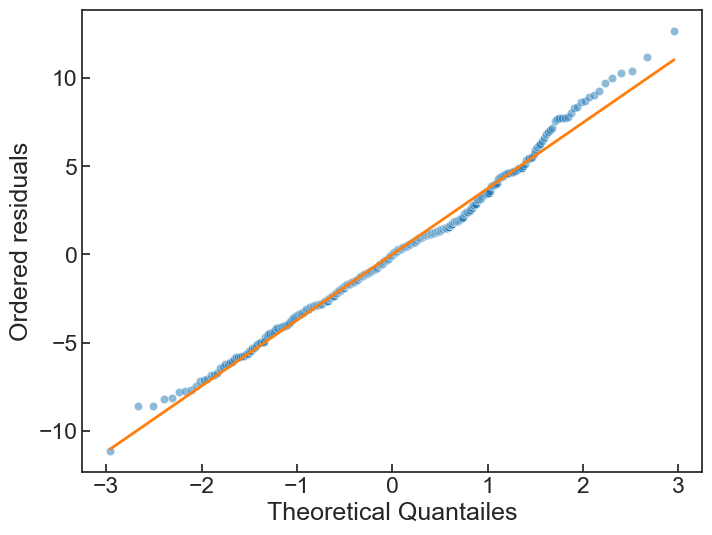

In [54]:
''' draw the quantile plot '''
# compare the distribution of residuals to normal distribution
results = stats.probplot(res_noout, dist="norm", plot=None)  # we will plot the results below.

# unpack the results
x_res, y_res = results[0]   # x: theoretical quantailes. y: ordered responses (sorted input)
slope, intercept, sqr_det = results[1]  # slope, intercept and the square root of the coefficient of determination (least-square fit)

fig, ax = plt.subplots()
sns.scatterplot(x=x_res, y=y_res, alpha=0.5, ax=ax)
ax.plot([np.min(x_res), np.max(x_res)], \
        [np.min(x_res)*slope+intercept, np.max(x_res)*slope+intercept], color='C1', lw=2)
ax.set_xlabel('Theoretical Quantailes')
ax.set_ylabel('Ordered residuals');

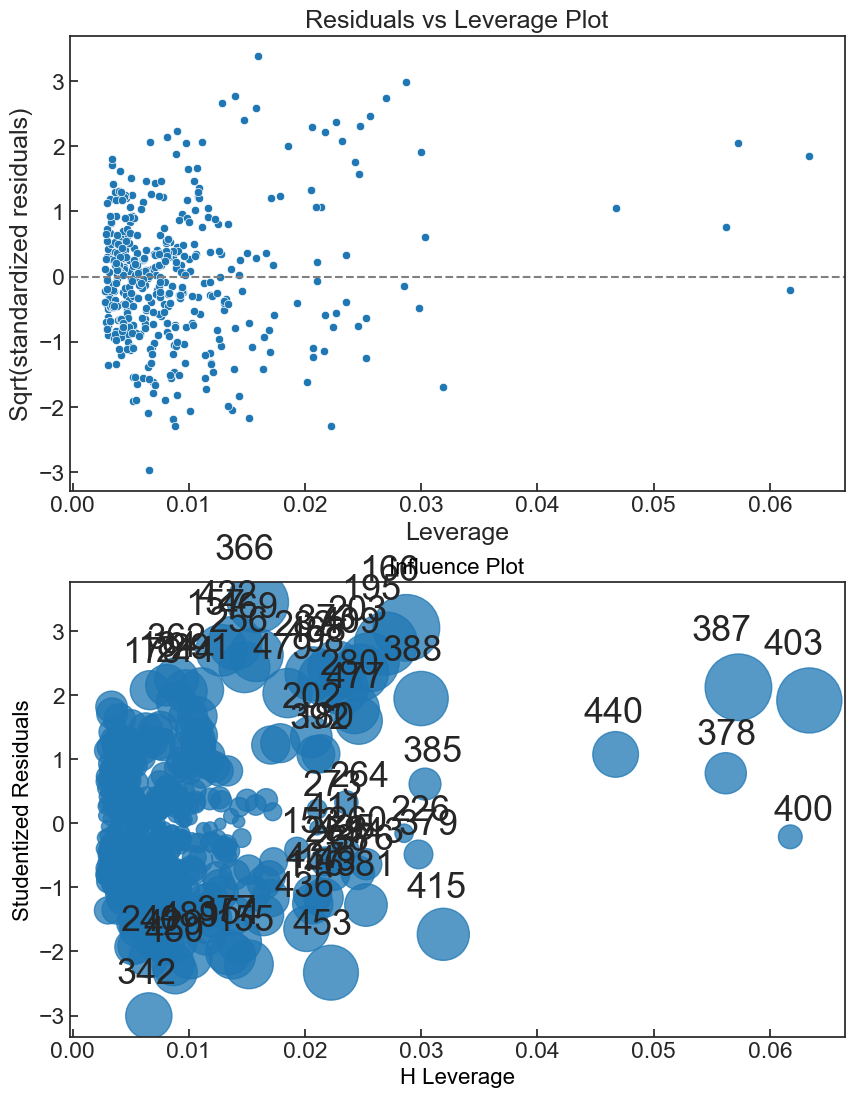

In [55]:
''' Draw figues for residual and influence plot !! '''

m_noout = ols('PRICE ~ CRIM + RM + PTRATIO', bos_nooutliers).fit()

stand_resids_noout = m_noout.resid_pearson  # square root of standardized residuals
influence_noout    = m_noout.get_influence()   # get influence
leverage_noout     = influence_noout.hat_matrix_diag    # get leverage

fig, axes = plt.subplots(2,1, figsize=(10,13))
# Residual vs Leverage Plot
sns.scatterplot(x=leverage_noout, y=stand_resids_noout, ax=axes[0])
axes[0].axhline(y=0, color='grey', linestyle='dashed')
axes[0].set_xlabel('Leverage')
axes[0].set_ylabel('Sqrt(standardized residuals)')
axes[0].set_title('Residuals vs Leverage Plot')

# PLot Cook's distance plot
#gg = sm.graphics.influence_plot(m_noout, criterion="cooks", ax=axes[1])
gg = sm.graphics.influence_plot(m_noout, criterion="DFFITS", ax=axes[1])